Text(0.5, 1.0, 'Final Output')

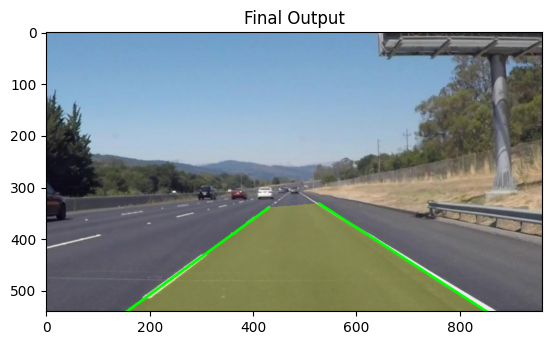

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from sklearn import linear_model


def find_lines(lines):
    slope_min = 0.3
    slope_max = 2
    x_right = []
    y_right = []
    
    x_left = []
    y_left = []

    if lines is None:
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            if m < -slope_min and m > -slope_max: #left
                if x1 > imshape[1]*0.5 or x2 > imshape[1]*0.5:
                    continue
                else:
                    x_left.append([x1])
                    x_left.append([x2])
                    y_left.append(y1)
                    y_left.append(y2)
            elif m > slope_min and m < slope_max: #right
                if x1 < imshape[1]*0.5 or x2 < imshape[1]*0.5:
                    continue
                else:
                    x_right.append([x1])
                    x_right.append([x2])
                    y_right.append(y1)
                    y_right.append(y2)
   
    x_right = np.array(x_right)
    y_right = np.array(y_right)
    model_ransac_right = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac_right.fit(x_right, y_right)
    line_x_right = np.arange(imshape[1]*0.55, imshape[1]*0.9)
    line_y_right = model_ransac_right.predict(line_x_right[:, np.newaxis])

    # # Check in-/outlier dataset in rightside data 
    # inlier_mask = model_ransac_right.inlier_mask_
    # outlier_mask = np.logical_not(inlier_mask)
    # plt.figure(12)
    # plt.scatter(x_right[inlier_mask], y_right[inlier_mask],
    #         c='steelblue', edgecolor='white',
    #         marker='o', label='Inliers')
    # plt.scatter(x_right[outlier_mask], y[outlier_mask],
    #          c='limegreen', edgecolor='white',
    #          marker='s', label='Outliers')
    # plt.title('in-/outliers')

    x_left = np.array(x_left)
    y_left = np.array(y_left)
    model_ransac_left = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac_left.fit(x_left, y_left)
    line_x_left = np.arange(imshape[1]*0.1, imshape[1]*0.45)
    line_y_left = model_ransac_left.predict(line_x_left[:, np.newaxis])

    left = [int(line_x_left[0]), int(line_y_left[0]), int(line_x_left[-1]), int(line_y_left[-1])]
    right = [int(line_x_right[0]), int(line_y_right[0]), int(line_x_right[-1]), int(line_y_right[-1])]


    return left, right


# Get all images
test_images = [mpimg.imread('test_video/videoFrames/' + i) for i in os.listdir('test_video/videoFrames/')]
test_image_names = ['test_video/videoFrames/'+i for i in os.listdir('test_video/videoFrames/')]


#----------------GET IMAGE-----------------
im = test_images[0]
imshape = im.shape
# plt.figure(1)
# plt.imshow(im)
# plt.title(test_image_names[0])

# -------------GREYSCALE IMAGE---------------
# Grayscale one color channel
grayIm = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# plt.figure(2)
# plt.imshow(grayIm,cmap='gray')
# plt.title('Greyscaled image')


#------------GAUSSIAN SMOOTHING-----------------
# Use low pass filter to remove noise. Will remove high freq stuff like noise and edges
# kernel_size specifies width/height of kernel, should be positive and odd
kernel_size = 9;
smoothedIm = cv2.GaussianBlur(grayIm, (kernel_size, kernel_size), 0)
# plt.figure(3)
# plt.imshow(smoothedIm,cmap='gray')
# plt.title('Smoothed image')


#-------------EDGE DETECTION---------------------
# finds gradient in x,y direction, gradient direction is perpendicular to edges
# checks pixels in gradient directions to see if they are local maximums, meaning on an edge
minVal = 60
maxVal = 150
edgesIm = cv2.Canny(smoothedIm, minVal, maxVal)
# plt.figure(4)
# implot = plt.imshow(edgesIm,cmap='gray')
# plt.title('Edge Detection')


#-------------------------CREATE MASK (Trizoidal) ----------------------------
# Create mask to only keep area defined by four coners
# Black out every area outside area
vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)

# defining a blank mask to start with, 0s with same shape of edgesIm
mask = np.zeros_like(edgesIm)   
          
# fill pixels inside the polygon defined by vertices"with the fill color  
color = 255
cv2.fillPoly(mask, vertices, color)

# # show mask
# plt.figure(5)
# plt.imshow(mask,cmap='gray')
# plt.title('Mask')
    
#----------------------APPLY MASK TO IMAGE-------------------------------
# create image only where mask and edge Detection image are the same
maskedIm = cv2.bitwise_and(edgesIm, mask)
    
# # Plot output of mask
# plt.figure(6)
# plt.imshow(maskedIm)
# plt.title('Masked Image')

# Plot masked edges image
maskedIm3Channel = cv2.cvtColor(maskedIm, cv2.COLOR_GRAY2BGR)


#-----------------------HOUGH LINES------------------------------------
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 45     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 100    # maximum gap in pixels between connectable line segments
lines = cv2.HoughLinesP(maskedIm, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)


left, right = find_lines(lines)

x1, y1, x2, y2 = right
x1N, y1N, x2N, y2N = left


#-----------------------Blend Image------------------------------
laneFill = im.copy()
vertices = np.array([[(x1,y1),(x2,y2),  (x1N,y1N), (x2N,y2N)]], dtype=np.int32)
color = [241,255,1]
cv2.fillPoly(laneFill, vertices, color)
opacity = .25
blendedImg =cv2.addWeighted(laneFill,opacity,im,1-opacity,0,im)
cv2.line(blendedImg,(x1,y1),(x2,y2),(0,255,0),4) # plot line on color image
cv2.line(blendedImg,(x1N,y1N),(x2N,y2N),(0,255,0),4) # plot line on color image

# Plot final output
plt.figure(10)
plt.imshow(blendedImg)
plt.title('Final Output')

In [25]:
import cv2

capture = cv2.VideoCapture(0)
capture.set(3, 640)
capture.set(4, 480)

# def find_lines(lines):
#     slope_min = 0.3
#     slope_max = 2
#     x_right = []
#     y_right = []
    
#     x_left = []
#     y_left = []

#     if lines is None:
#         return
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             m = (y2-y1)/(x2-x1)
#             if m < -slope_min and m > -slope_max: #left
#                 if x1 > imshape[1]*0.5 or x2 > imshape[1]*0.5:
#                     continue
#                 else:
#                     x_left.append([x1])
#                     x_left.append([x2])
#                     y_left.append(y1)
#                     y_left.append(y2)
#             elif m > slope_min and m < slope_max: #right
#                 if x1 < imshape[1]*0.5 or x2 < imshape[1]*0.5:
#                     continue
#                 else:
#                     x_right.append([x1])
#                     x_right.append([x2])
#                     y_right.append(y1)
#                     y_right.append(y2)
   
#     x_right = np.array(x_right)
#     y_right = np.array(y_right)
#     model_ransac_right = linear_model.RANSACRegressor(linear_model.LinearRegression())
#     model_ransac_right.fit(x_right, y_right)
#     line_x_right = np.arange(imshape[1]*0.55, imshape[1]*0.9)
#     line_y_right = model_ransac_right.predict(line_x_right[:, np.newaxis])

#     x_left = np.array(x_left)
#     y_left = np.array(y_left)
#     model_ransac_left = linear_model.RANSACRegressor(linear_model.LinearRegression())
#     model_ransac_left.fit(x_left, y_left)
#     line_x_left = np.arange(imshape[1]*0.1, imshape[1]*0.45)
#     line_y_left = model_ransac_left.predict(line_x_left[:, np.newaxis])

#     left = [int(line_x_left[0]), int(line_y_left[0]), int(line_x_left[-1]), int(line_y_left[-1])]
#     right = [int(line_x_right[0]), int(line_y_right[0]), int(line_x_right[-1]), int(line_y_right[-1])]

#     result = (left, right)
#     return result


while True:
    ret, img = capture.read()

    if not ret:
        print('Failure: loading video')
        break
    if cv2.waitKey(1) & 0xFF == 27: 
        break

    #----------------GET IMAGE-----------------
    imshape = img.shape
    grayIm = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # GAUSSIAN FILTER
    kernel_size = 9
    smoothedIm = cv2.GaussianBlur(grayIm, (kernel_size, kernel_size), 0)

    # EDGE DETECTION
    minVal = 60
    maxVal = 150
    edgesIm = cv2.Canny(smoothedIm, minVal, maxVal)

    # CREATE MASKED AREA: TRIZOIDAL
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    mask = np.zeros_like(edgesIm)             
    color = 255
    cv2.fillPoly(mask, vertices, color)
       
    # APPLY MASK
    maskedIm = cv2.bitwise_and(edgesIm, mask)       

    # HOUGH LINES
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 0  #40 # minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines = cv2.HoughLinesP(maskedIm, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)

    # LINE DETECTION USING RANSAC REGRESSOR 
    slope_min = 0.3
    slope_max = 2
    x_right = []
    y_right = []
    
    x_left = []
    y_left = []

    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                m = (y2-y1)/(x2-x1)
                if m < -slope_min and m > -slope_max: #left
                    if x1 > imshape[1]*0.5 or x2 > imshape[1]*0.5:
                        continue
                    else:
                        x_left.append([x1])
                        x_left.append([x2])
                        y_left.append(y1)
                        y_left.append(y2)
                elif m > slope_min and m < slope_max: #right
                    if x1 < imshape[1]*0.5 or x2 < imshape[1]*0.5:
                        continue
                    else:
                        x_right.append([x1])
                        x_right.append([x2])
                        y_right.append(y1)
                        y_right.append(y2)
   
    x_right = np.array(x_right).reshape(-1,1)
    y_right = np.array(y_right).reshape(-1,1)
    if not x_right.any() or not y_right.any():
        x1, y1, x2, y2 = int(imshape[1]), int(imshape[0]), int(imshape[1]-0.000001), int(imshape[0]-0.000001)
    else:
        model_ransac_right = linear_model.RANSACRegressor(linear_model.LinearRegression())
        model_ransac_right.fit(x_right, y_right)
        line_x_right = np.arange(imshape[1]*0.55, imshape[1]*0.9)
        line_y_right = model_ransac_right.predict(line_x_right[:, np.newaxis])
        x1, y1, x2, y2 = [int(line_x_right[0]), int(line_y_right[0]), int(line_x_right[-1]), int(line_y_right[-1])]

    x_left = np.array(x_left)
    y_left = np.array(y_left)
    if not x_left.any() or not y_left.any():
        x1N, y1N, x2N, y2N = 0, 0, 1, 1
    else:
        model_ransac_left = linear_model.RANSACRegressor(linear_model.LinearRegression())
        model_ransac_left.fit(x_left, y_left)
        line_x_left = np.arange(imshape[1]*0.1, imshape[1]*0.45)
        line_y_left = model_ransac_left.predict(line_x_left[:, np.newaxis])
    
    # FINAL IMAGE DRAWN LINES
    laneFill = img.copy()
    vertices = np.array([[(x1,y1),(x2,y2),  (x1N,y1N), (x2N,y2N)]], dtype=np.int32)
    color = [241,255,1]
    cv2.fillPoly(laneFill, vertices, color)
    opacity = .25
    blendedImg =cv2.addWeighted(laneFill,opacity,img,1-opacity,0,img)
    cv2.line(blendedImg,(x1,y1),(x2,y2),(0,255,0),4) # plot line on color image
    cv2.line(blendedImg,(x1N,y1N),(x2N,y2N),(0,255,0),4) # plot line on color image
    cv2.imshow("Video", blendedImg)

Failure: loading video
